# LABORATORIO 13
---
```
Universidad Nacional de San Antonio Abad del Cusco
Asignatura: Deep Learning
Docente   : Ivan Cesar Medrano Valencia
Autores   : Etson Ronaldao Rojas Cahuana
Fecha     : 17/01/2022
Lugar     : Cusco, Perú
Proposito : Diseñar una red neuronal convolucional basada en YOLO para detectar objetos en
            un video.
```
---

# Importar las librerias necesarias

In [ ]:
import numpy as np
import argparse
import time
import cv2
import os

import matplotlib.pyplot as plt

La versión de OpenCV es

In [ ]:
print (cv2. __version__)

4.5.4-dev


En particular usaremos extensivamente el paquete y funciones ```cv2.dnn``` que permiten implementar yolo de una manera muy fácil y sencilla en cualquier aplicación escrita en Python donde se trabaje con imágenes. 

Primero necesitamos cargar los nombres de las clases en las que se ha entrenado la red. Ten en cuenta que la red que utilicemos solo podrá reconocer las clases en las que se ha formado.

In [ ]:
labelsPath = "yolo-coco/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")
LABELS[1:5]

['bicycle', 'car', 'motorbike', 'aeroplane']

Ahora, para cada clase, generaremos un color aleatorio. Usaremos este color más adelante cuando dibujemos los cuadros delimitadores alrededor de los objetos.

In [ ]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [ ]:
COLORS[0:5]

array([[102, 220, 225],
       [ 95, 179,  61],
       [234, 203,  92],
       [  3,  98, 243],
       [ 14, 149, 245]], dtype=uint8)

Necesitamos ahora cargar el archivo ```cfg``` (donde se describe la estructura de la red), y los pesos pre-entrenados.

In [ ]:
weightsPath = "yolo-coco/yolov3.weights"
configPath = "yolo-coco/yolov3.cfg"

In [ ]:
print("[INFO] Cargando YOLO desde el disco...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] Cargando YOLO desde el disco...


In [ ]:
# determinar solo los nombres de capa *output* que necesitamos de YOLO
ln = net.getLayerNames()
#ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
ln

['yolo_82', 'yolo_94', 'yolo_106']

Ahora cargamos el video que queremos analizar. 

In [ ]:
#Obtener ruta del video
direccion_video = 'video/test_360p.mp4'

#Obtener el video con videocapture
video = cv2.VideoCapture(direccion_video)

#Obtener informacion del video
length = video.get(cv2.CAP_PROP_FRAME_COUNT)
width  = video.get(cv2.CAP_PROP_FRAME_WIDTH)
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps    = video.get(cv2.CAP_PROP_FPS)

#Mostrar informacion necesaria del video
print("===INFORMACION DEL VIDEO===")
print("Tamaño del video: ",width," x ",height)
print("Numero de fotogramas de la secuencia de video: ",length)
print("Numero de fotogramas por segundo: ",fps)

# Preparando variable para escribir en disco
writer = None

# Preparando variables para dimensiones espaciales de los marcos
h, w = None, None

#Inicializar probabilidad mínima para eliminar predicciones débiles
p_min = 0.5

#Umbral cuando se aplica supresión no maxia
thres = 0.

#Numero de frames para mostrar el antes y despues del procesamiento del video
particiones = 5

#Particion de los frames, se utilizara para guardar secuencialmente los fotogramas en un vector
frame_partido = int(length/particiones)-1

===INFORMACION DEL VIDEO===
Tamaño del video:  640.0  x  352.0
Numero de fotogramas de la secuencia de video:  160.0
Numero de fotogramas por segundo:  29.427452134409886


# Obtener frames del video
Se extraen los fotogramas del video inicial con fines de demostramiento.

In [ ]:
Contador_frames = 0
frame_inicial=frame_partido
video_frame_original=[]
while True:
    ret, frame = video.read()
    if not ret:
        break
    if Contador_frames==frame_inicial:
        video_frame_original.append(frame)
        print("Fotograma",frame_inicial,"guardado.")
        frame_inicial = frame_inicial + frame_partido
    Contador_frames=Contador_frames + 1

Fotograma 31 guardado.
Fotograma 62 guardado.
Fotograma 93 guardado.
Fotograma 124 guardado.
Fotograma 155 guardado.


# Detectar objetos de un video

Guardar los fotogramas del video con fines de demostracion del funcionamiento.

In [ ]:
Contador_frames=0
video_frame_procesado=[]
frame_inicial=frame_partido
video = cv2.VideoCapture(direccion_video)
#Hacer un bucle donde se extraerá cada frame del video y aplicar el reconocimiento de objetos sobre este
while True:
    ret, frame = video.read()
    if not ret:
        break

    #Obtener las dimensiones del marco por una vez, ya que cada vez las dimensiones serán las mismas
    if w is None or h is None:
        # Cortar y obtener la altura, el ancho de la imagen.
        h, w = frame.shape[:2]

    #Necesitamos cambiar el tamaño de la imagen a un cuadrado de 416x416 píxeles y hacer un pase hacia adelante a través de la red.
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)

    # Realizar un pase hacia adelante del detector de objetos YOLO, dándonos nuestros cuadros delimitadores y probabilidades asociadas.
    net.setInput(blob)
    output_from_network = net.forward(ln)

    #Preparar listas para delimitar cuadros, confidencias y números de clase detectados.
    bounding_boxes = []
    confidences = []
    class_numbers = []

    #Recorriendo todas las capas de salida después del pase de avance
    for result in output_from_network:
        for detected_objects in result:
            scores = detected_objects[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > p_min:
                box_current = detected_objects[0:4] * np.array([w, h, w, h])
                #Desde el formato de datos YOLO, podemos obtener las coordenadas de la esquina superior izquierda
                #que son x_min y y_min
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                #Adición de resultados en listas preparadas
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    #Implementación de supresión no máxima de cuadros delimitadores dados
    #Con esta técnica excluimos algunos de los cuadros delimitadores si
    #las confianzas correspondientes son bajas o hay otro
    #cuadro delimitador para esta región con mayor confianza
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, p_min, thres)

    #Debe existir al menos una detección
    if len(results) > 0:
        for i in results.flatten():
            # Obtener las coordenadas actuales del cuadro delimitador, su ancho y alto      
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

            #Preparando el color para el cuadro delimitador actual
            colour_box_current = COLORS[class_numbers[i]].tolist()

            #Dibujar un cuadro delimitador en la imagen original
            cv2.rectangle(frame, (x_min, y_min),
                          (x_min + box_width, y_min + box_height),
                          colour_box_current, 2)

            #Preparando texto con etiqueta y confianza para el cuadro delimitador actual
            text_box_current = '{}: {:.4f}'.format(LABELS[int(class_numbers[i])],
                                                   confidences[i])

            #Poner texto con etiqueta y confianza en la imagen original
            cv2.putText(frame, text_box_current, (x_min, y_min - 5),
                        cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)

    #Guardar los frames procesados en base a la cantidad de particiones que se define al inicio
    #en un vector para ser mostrado posteriormente
    if Contador_frames==frame_inicial:
        video_frame_procesado.append(frame)
        print("Fotograma",frame_inicial,"procesado y guardado.")
        frame_inicial = frame_inicial + frame_partido
    
    Contador_frames=Contador_frames + 1
    
    #Guardar los frames procesados en un archivo temporal del disco.
    if writer is None:
        resultVideo = cv2.VideoWriter_fourcc(*'mp4v')

        #Escribir el frame actual en el archivo de video
        writer = cv2.VideoWriter('video/result-video_1.mp4', resultVideo, 30,
                                 (frame.shape[1], frame.shape[0]), True)

    #Escribir el frame procesado en el archivo
    writer.write(frame)

Fotograma 31 procesado y guardado.
Fotograma 62 procesado y guardado.
Fotograma 93 procesado y guardado.
Fotograma 124 procesado y guardado.
Fotograma 155 procesado y guardado.


Guardar y completar la escritura en disco del video procesado.

In [ ]:
video.release()
writer.release()

# Mostrar fotogramas guardados durante el proceso

Se muestran los fotogramas originales del video y los fotogramas procesados, se extrajeron 5 fotogramas

==========FOTOGRAMAS VIDEO ORIGINAL==========


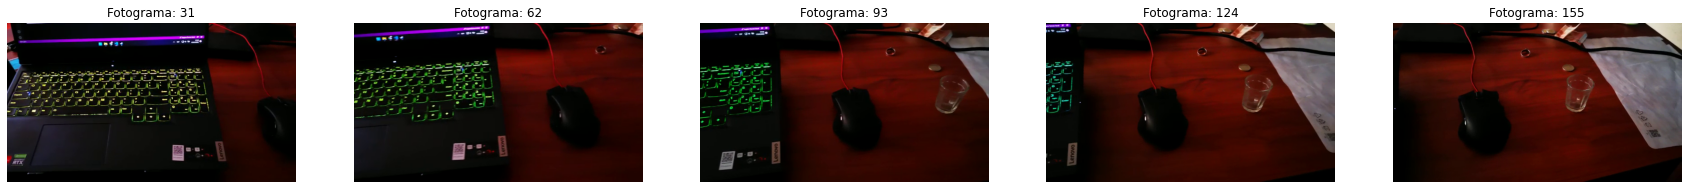

==========FOTOGRAMAS VIDEO PROCESADO==========


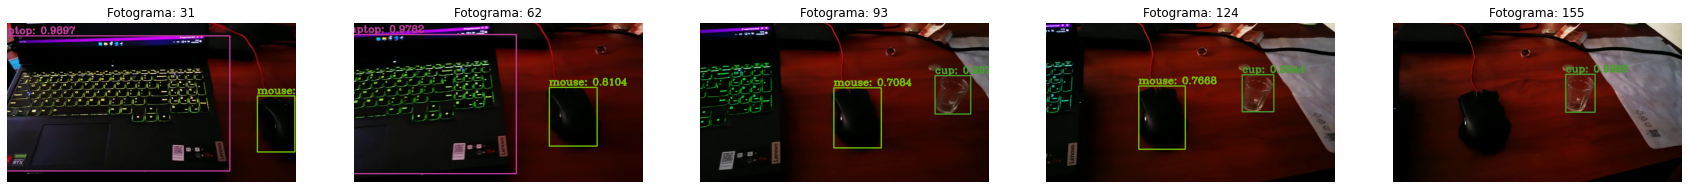

In [ ]:
print("==========FOTOGRAMAS VIDEO ORIGINAL==========")
plt.figure(figsize=(30,30))
for i in range(1, particiones+1):
    plt.subplot(1,particiones,i)
    plt.grid(False)
    fotograma = video_frame_original[i-1]
    plt.imshow(fotograma[:,:,::-1])
    plt.axis('off')
    plt.title("Fotograma: "+str(frame_partido*i))
plt.show()
print("==========FOTOGRAMAS VIDEO PROCESADO==========")
plt.figure(figsize=(30,30))
plt.title("Fotograma del video procesado")
for i in range(1, particiones+1):
    plt.subplot(1,particiones,i)
    plt.grid(False)
    fotograma = video_frame_procesado[i-1]
    plt.imshow(fotograma[:,:,::-1])
    plt.axis('off')
    plt.title("Fotograma: "+str(frame_partido*i))
plt.show()